In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importar las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Cargar el archivo
path = "/content/drive/MyDrive/TFM/MatriculaciónMes.xlsx"
df = pd.read_excel(path)

# Mostrar las primeras filas, información y si hay nulos del DataFrame
print(df.head())
print(df.info())
print(df.isna().sum())

       fecha  num_matriculado
0 2010-01-01            71200
1 2010-02-01            92976
2 2010-03-01           126607
3 2010-04-01            95400
4 2010-05-01           104491
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            180 non-null    datetime64[ns]
 1   num_matriculado  180 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB
None
fecha              0
num_matriculado    0
dtype: int64


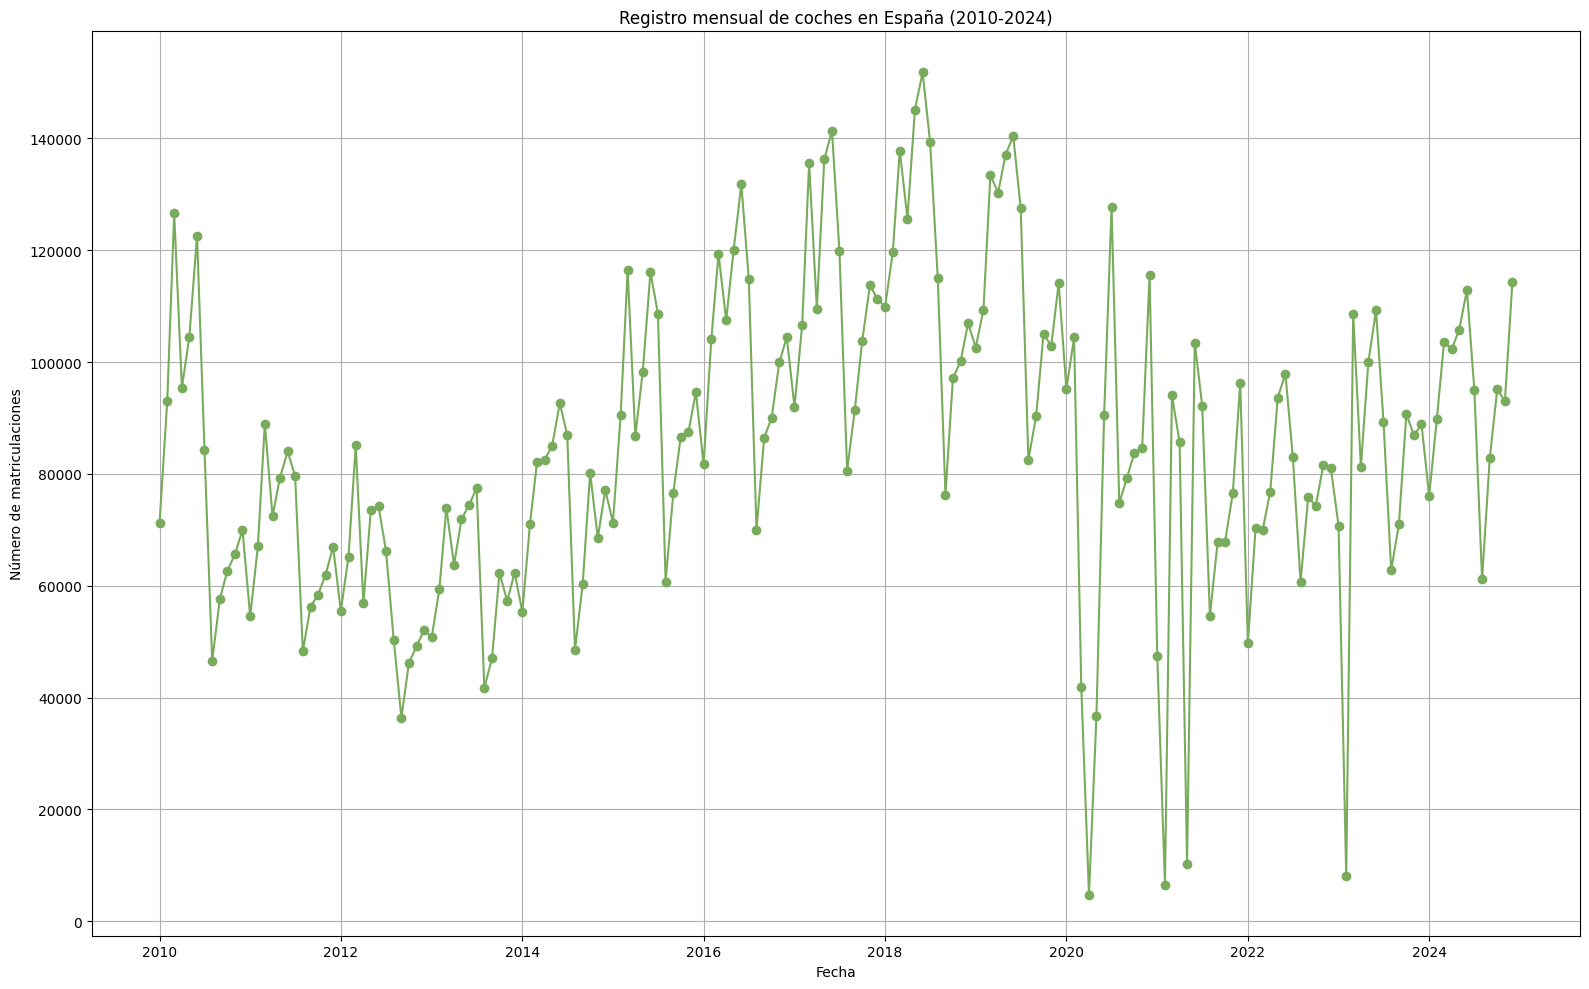

In [ ]:
# Visualización del registro mensual de coches en España (2010-2024)
plt.figure(figsize=(16, 10))
plt.plot(df["fecha"], df["num_matriculado"], marker="o", color='#79AB5C')
plt.title("Registro mensual de coches en España (2010-2024)")
plt.xlabel("Fecha")
plt.ylabel("Número de matriculaciones")
plt.grid(True)
plt.tight_layout()
plt.show()

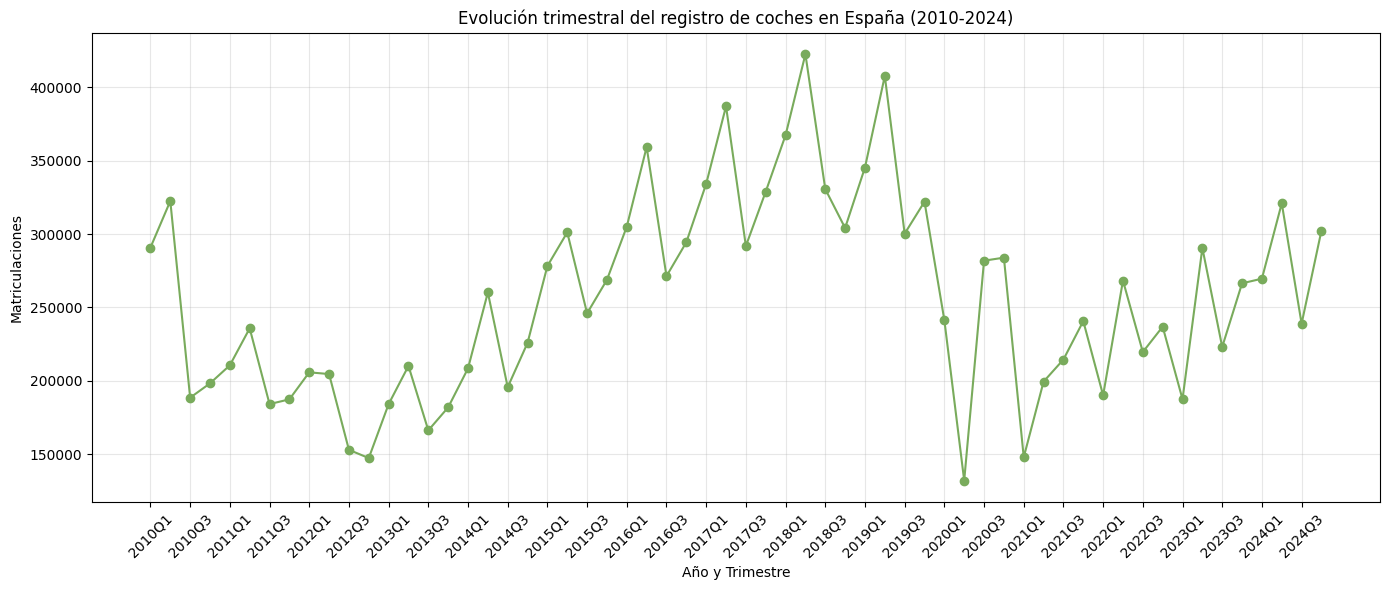

In [ ]:
# Visualización del registro trimetral de coches en España (2010-2024)
df["year"] = df["fecha"].dt.year
df["quarter"] = df["fecha"].dt.quarter

df_quarter = df.groupby(["year", "quarter"], as_index=False)["num_matriculado"].sum()

df_quarter["x_label"] = df_quarter["year"].astype(str) + "Q" + df_quarter["quarter"].astype(str)

plt.figure(figsize=(14, 6))
plt.plot(df_quarter["x_label"], df_quarter["num_matriculado"], marker="o", color="#79AB5C")
plt.title("Evolución trimestral del registro de coches en España (2010-2024)")
plt.xlabel("Año y Trimestre")
plt.ylabel("Matriculaciones")
plt.xticks(df_quarter["x_label"][::2], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

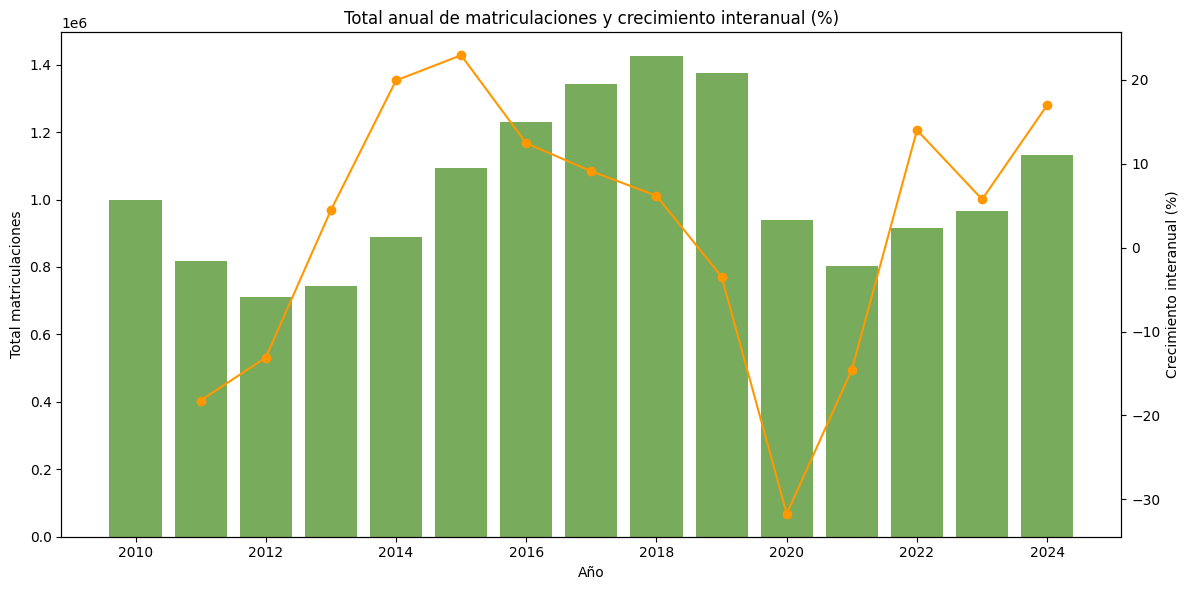

In [ ]:
# Generar resumen anual y tasa de crecimiento
df["año"] = df["fecha"].dt.year
df_year = df.groupby("año")["num_matriculado"].sum().reset_index()
df_year["yoy"] = df_year["num_matriculado"].pct_change()*100

# Configurar figura con dos ejes
fig, ax1 = plt.subplots(figsize=(12,6))

# Gráfico de barras: Total anual de matriculaciones
color_bar = "#79AB5C"
ax1.bar(df_year["año"], df_year["num_matriculado"], color=color_bar, label="Total matriculaciones")
ax1.set_xlabel("Año")
ax1.set_ylabel("Total matriculaciones", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# Crear segundo eje Y para la tasa de crecimiento
ax2 = ax1.twinx()
color_line = "#FF9800"
ax2.plot(df_year["año"], df_year["yoy"], marker="o", color=color_line, label="Crecimiento interanual (%)")
ax2.set_ylabel("Crecimiento interanual (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Añadir título
plt.title("Total anual de matriculaciones y crecimiento interanual (%)")
fig.tight_layout()
# Mostrar el gráfico
plt.show()

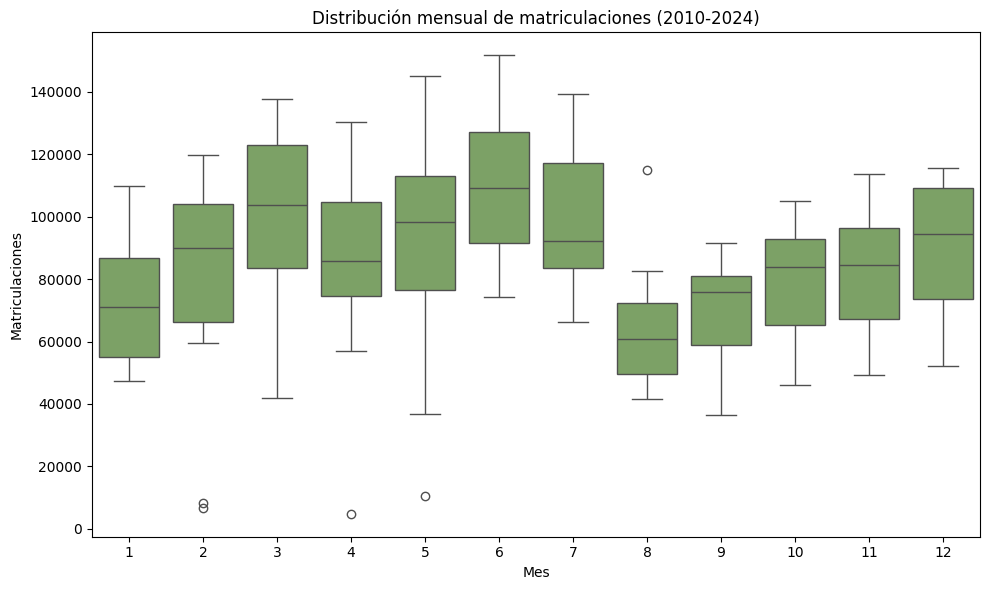

In [ ]:
# Gráfico boxplot de la Distribución mensual de matriculaciones (2010-2024)
df["mes"] = df["fecha"].dt.month
plt.figure(figsize=(10,6))
sns.boxplot(x="mes", y="num_matriculado", data=df, color="#79AB5C")
plt.title("Distribución mensual de matriculaciones (2010-2024)")
plt.xlabel("Mes")
plt.ylabel("Matriculaciones")
plt.tight_layout()
plt.show()

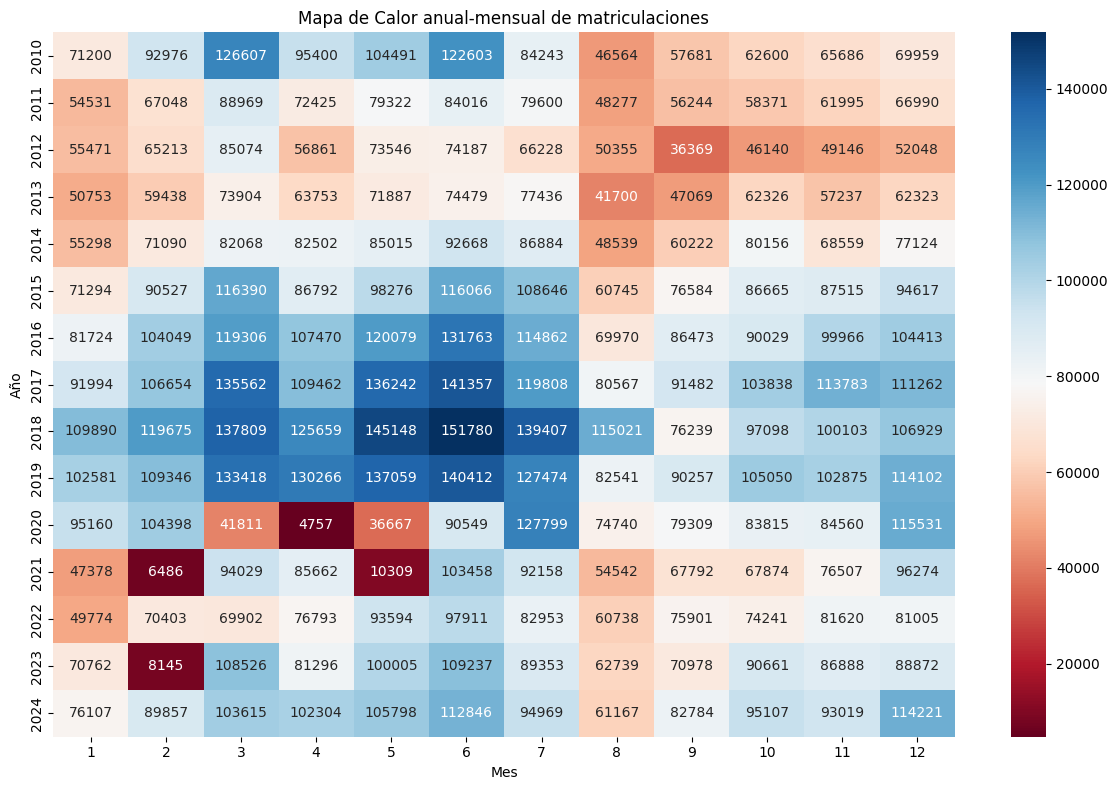

In [ ]:
# Mapa de calor de la matriculación mensual anual (2010-2024)
pivot = df.pivot_table(index="año", columns="mes", values="num_matriculado", aggfunc="sum")
plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="RdBu")
plt.title("Mapa de Calor anual-mensual de matriculaciones")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.tight_layout()
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install statsmodels

In [ ]:
# Importar librerías necesarias para los modelos
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


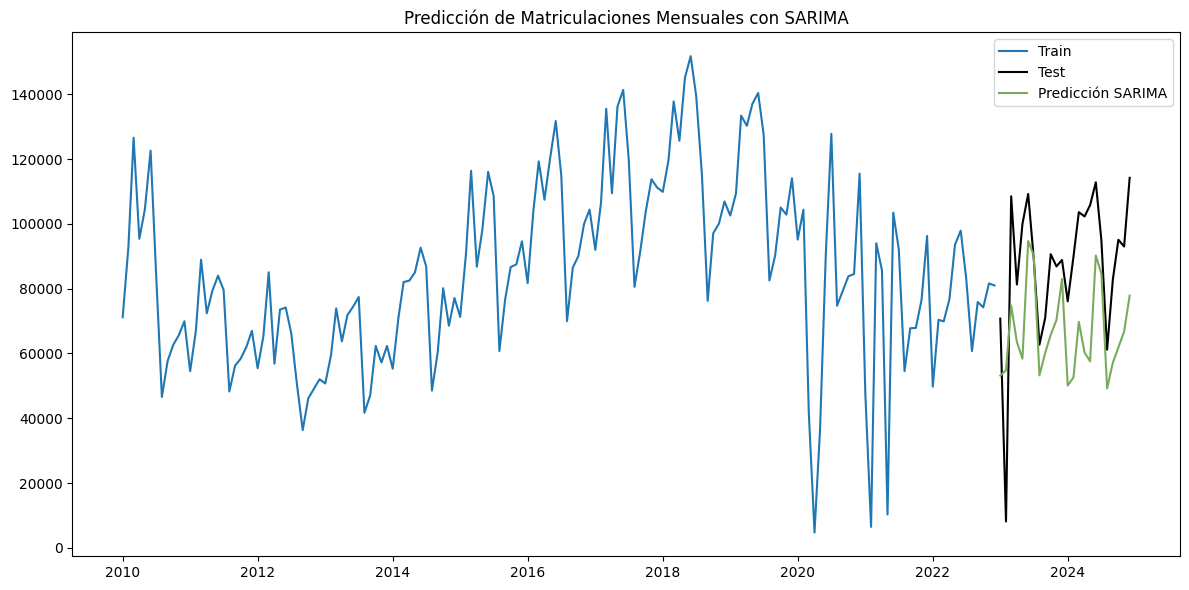

MAE: 24754, RMSE: 28022, R²: -0.603


In [ ]:
# Preparación de la serie temporal ordenando por fecha y estableciendo la fecha como índice
df = df.sort_values("fecha")
df_ts = df.set_index("fecha")["num_matriculado"]

# Dividir los datod en conjuntos de entrenamiento (enero 2010-diciembre 2022) y prueba (enero 2023-diciembre 2024)
train = df_ts[df_ts.index < "2023-01-01"]
test = df_ts[df_ts.index >= "2023-01-01"]

# Configuración del modelo SARIMA
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit(disp=False)

# Predicción
pred = result.predict(start=test.index[0], end=test.index[-1])

# Visualización
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="black")
plt.plot(pred, label="Predicción SARIMA", color="#79AB5C")
plt.legend()
plt.title("Predicción de Matriculaciones Mensuales con SARIMA")
plt.tight_layout()
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)
print(f"MAE: {mae:.0f}, RMSE: {rmse:.0f}, R²: {r2:.3f}")

In [ ]:
!pip install xgboost scikit-learn

In [ ]:
# Preparación de características temporales
df_ml = df.copy()
df_ml["year"] = df_ml["fecha"].dt.year
df_ml["month"] = df_ml["fecha"].dt.month
df_ml["quarter"] = df_ml["fecha"].dt.quarter

# Creación de variables de retardo(lags)
for lag in [1, 12]:
    df_ml[f"lag_{lag}"] = df_ml["num_matriculado"].shift(lag)

# Eliminar filas con NaN
df_ml = df_ml.dropna()

# Definir las variables de entrada (X) y la variable objetivo (y)
X = df_ml[["year", "month", "quarter", "lag_1", "lag_12"]]
y = df_ml["num_matriculado"]

# Dividir los datos en conjuntos de entrenamiento y prueba
split_date = "2023-01-01"
X_train = X[df_ml["fecha"] < split_date]
y_train = y[df_ml["fecha"] < split_date]
X_test = X[df_ml["fecha"] >= split_date]
y_test = y[df_ml["fecha"] >= split_date]

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejor combinación de hiperparámetros: {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}


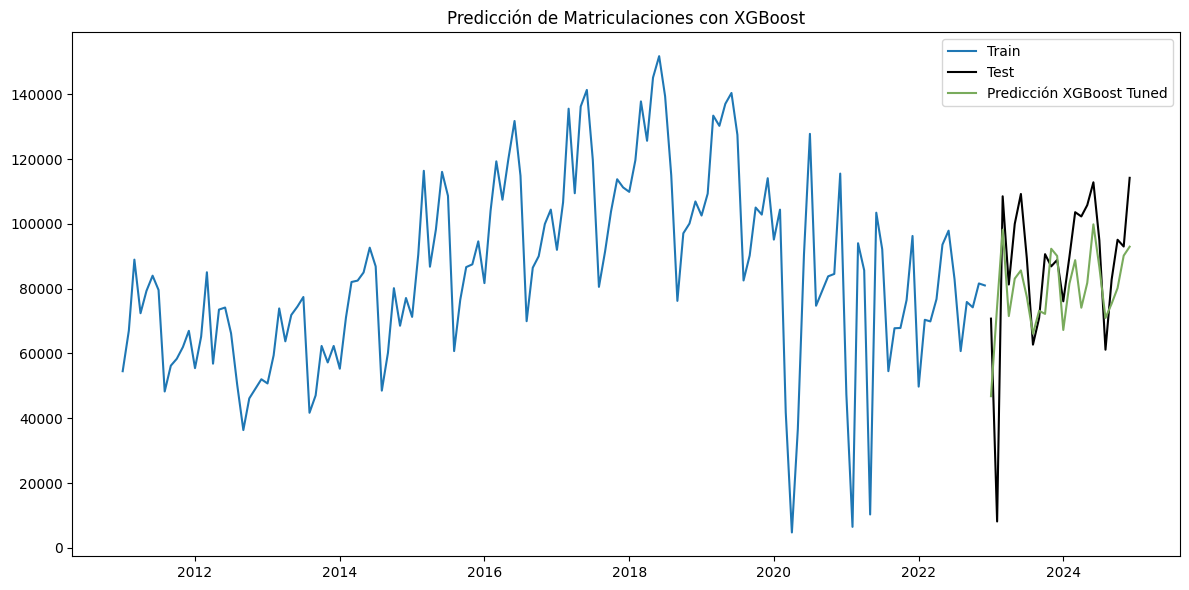

MAE=14793, RMSE=19756, R²=0.203


In [ ]:
# Construir el modelo
xgb = xgb.XGBRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 1],
    "colsample_bytree": [0.7, 1]
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=5,
                           scoring="neg_mean_squared_error",
                           n_jobs=-1,
                           verbose=2)

# Entrenamiento del modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Resultados de la optimización
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)

# Creación del modelo final con mejores parámetros
best_model = grid_search.best_estimator_
# Predicción en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Visualización de resultados
plt.figure(figsize=(12,6))
plt.plot(df_ml["fecha"][df_ml["fecha"] < split_date], y_train, label="Train")
plt.plot(df_ml["fecha"][df_ml["fecha"] >= split_date], y_test, label="Test", color="black")
plt.plot(df_ml["fecha"][df_ml["fecha"] >= split_date], y_pred, label="Predicción XGBoost Tuned", color="#79AB5C")
plt.legend()
plt.title("Predicción de Matriculaciones con XGBoost")
plt.tight_layout()
plt.show()

# Evaluación del modelo
mae_ml = mean_absolute_error(y_test, y_pred)
rmse_ml = np.sqrt(mean_squared_error(y_test, y_pred))
r2_ml = r2_score(y_test, y_pred)

# Mostrar el resultado
print(f"MAE={mae_ml:.0f}, RMSE={rmse_ml:.0f}, R²={r2_ml:.3f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejor combinación de hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


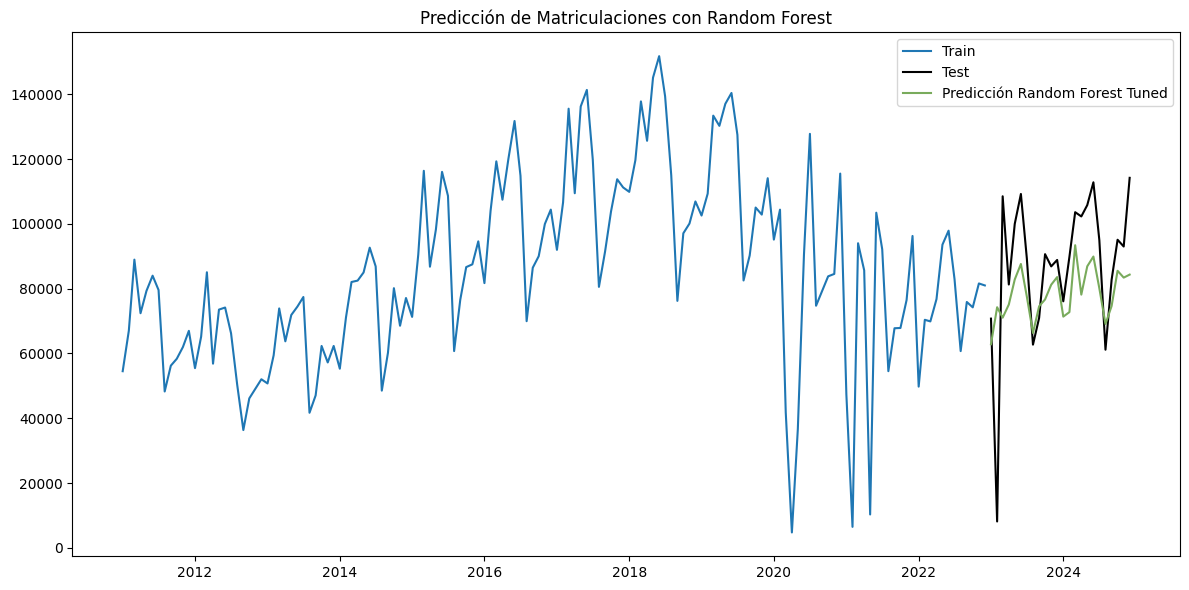

MAE=15761, RMSE=20785, R²=0.118


In [ ]:
# Construir el modelo
rf = RandomForestRegressor(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Configurar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring="neg_mean_absolute_error", verbose=2)

# Entrenamiento del modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Resultados de la optimización
print("Mejor combinación de hiperparámetros:", grid_search.best_params_)

# Creación del modelo final con mejores parámetros
best_rf = grid_search.best_estimator_
# Predicción en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Visualización de resultados
plt.figure(figsize=(12,6))
plt.plot(df_ml["fecha"][df_ml["fecha"] < split_date], y_train, label="Train")
plt.plot(df_ml["fecha"][df_ml["fecha"] >= split_date], y_test, label="Test", color="black")
plt.plot(df_ml["fecha"][df_ml["fecha"] >= split_date], y_pred, label="Predicción Random Forest Tuned", color="#79AB5C")
plt.legend()
plt.title("Predicción de Matriculaciones con Random Forest")
plt.tight_layout()
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Mostrar el resultado
print(f"MAE={mae:.0f}, RMSE={rmse:.0f}, R²={r2:.3f}")